In [69]:
# import dependencies
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")


In [70]:
# df = pd.read_csv('fake.csv', usecols = ['uuid','author','title','text','language','site_url','country'])
df = pd.read_csv('../summaries.csv', )
# df = df[df.language == 'english']
# df = df[df['text'].map(type) == str]
# df['title'].fillna(value="", inplace=True)
# df.dropna(axis=0, inplace=True, subset=['text'])
# shuffle the data
df = df.sample(frac=1.0)
df.reset_index(drop=True,inplace=True)
df.head()

,abstract
0,Abstract.In operations of increasingly complex...
1,"Abstract:In this paper, an attempt has b..."
2,Human iris is considered a reliable and accura...
3,ABSTRACT We focus on the problem of designing ...
4,Abstract—Human iris contains rich textural inf...


In [117]:
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    
    text = nltk.word_tokenize(text)
#     print('sdfdfsfsdf',  text)
    return text

stop_words = stopwords.words('english')
# print(stop_words)
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
#     print(text)
    words = []
    for word in text:
        if word not in stop_words:
            words.append(word)
    return words
#     return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
#         print('dsfsdfsdfs',text)
#         text = [stemmer.stem(word) for word in text]
#         print(text)
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))



In [118]:
# clean text and title and create new column "tokenized"
t1 = time.time()
df['tokenized'] = df['abstract'].apply(apply_all) #+ df['title'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(df), "articles:", (t2-t1)/60, "min")
print(df)


Time to clean and tokenize 6 articles: 0.0006644527117411295 min
                                            abstract  \
0  Abstract.In operations of increasingly complex...   
1  Abstract:In  this  paper,  an  attempt  has  b...   
2  Human iris is considered a reliable and accura...   
3  ABSTRACT We focus on the problem of designing ...   
4  Abstract—Human iris contains rich textural inf...   
5  Iris recognition systems are vulnerable to pre...   

                                           tokenized  
0  [abstractin, operations, increasingly, complex...  
1  [abstractin, paper, attempt, made, review, var...  
2  [human, iris, considered, reliable, accurate, ...  
3  [abstract, focus, problem, designing, network,...  
4  [abstracthuman, iris, contains, rich, textural...  
5  [iris, recognition, systems, vulnerable, prese...  


In [119]:
# first get a list of all words
all_words = [word for item in list(df['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
print(all_words)
len(fdist) # number of unique words

['abstractin', 'operations', 'increasingly', 'complex', 'telecommunication', 'networkscharacterization', 'system', 'state', 'choosing', 'optimal', 'operation', 'challenges', 'one', 'possible', 'approach', 'utilize', 'statistical', 'uncertain', 'information', 'inthe', 'network', 'management', 'paper', 'gives', 'overview', 'work', 'amarkov', 'logic', 'network', 'model', 'mln', 'used', 'mobile', 'network', 'analysis', 'withan', 'rdfbased', 'faceted', 'search', 'interface', 'monitor', 'control', 'behavior', 'themln', 'reasoner', 'experiments', 'based', 'prototype', 'implementation', 'indicatethat', 'combination', 'mln', 'semantic', 'web', 'technologies', 'effectivelyutilized', 'network', 'status', 'characterization', 'optimization', 'visualization', 'abstractin', 'paper', 'attempt', 'made', 'review', 'various', 'existing', 'generations', 'mobile', 'wireless', 'technology', 'terms', 'portals', 'performance', 'advantages', 'disadvantages', 'paper', 'throws', 'light', 'evolution', 'developmen

394

In [123]:
# choose k and visually inspect the bottom 10 words of the top k
k = 100
top_k_words = fdist.most_common(k)
top_k_words[-10:]



[('increasingly', 1),
 ('complex', 1),
 ('telecommunication', 1),
 ('networkscharacterization', 1),
 ('system', 1),
 ('state', 1),
 ('choosing', 1),
 ('optimal', 1),
 ('operation', 1),
 ('challenges', 1)]

In [126]:
# choose k and visually inspect the bottom 10 words of the top k
k = 12
top_k_words = fdist.most_common(k)
top_k_words[-10:]



[('paper', 8),
 ('spoofing', 8),
 ('mobile', 7),
 ('wireless', 7),
 ('technology', 7),
 ('architecture', 7),
 ('information', 6),
 ('proposed', 6),
 ('recognition', 5),
 ('attack', 5)]

In [127]:
# define a function only to keep words in the top k words
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [129]:
df['tokenized'] = df['tokenized'].apply(keep_top_k_words)
print(df['tokenized'])

0    [information, network, paper, network, mobile,...
1    [paper, mobile, wireless, technology, paper, m...
2    [iris, recognition, information, recognition, ...
3    [network, architecture, proposed, architecture...
4    [iris, information, spoofing, paper, iris, rec...
5    [iris, recognition, network, architecture, iri...
Name: tokenized, dtype: object


In [130]:


# document length
df['doc_len'] = df['tokenized'].apply(lambda x: len(x))
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))




length of list: 6 
average document length 15.333333333333334 
minimum document length 6 
maximum document length 29


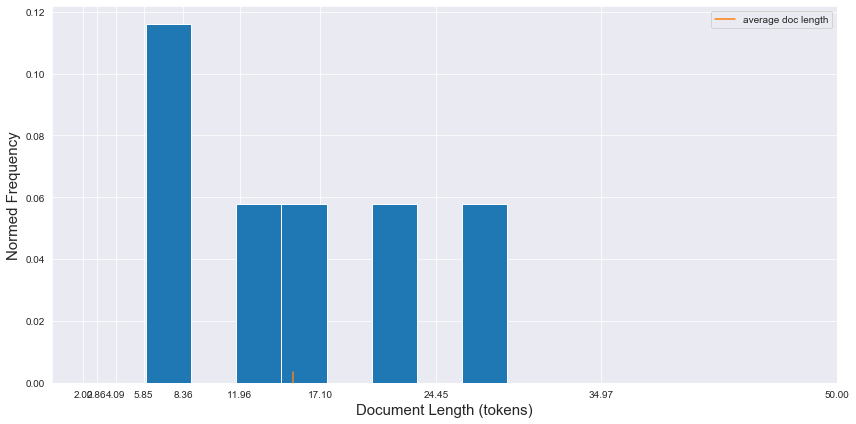

In [148]:
# plot a histogram of document length
num_bins = 8
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins, density=1)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(2),stop=np.log10(50),num=10, base=10.0))
plt.xlim(0,50)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0035,100)], np.linspace(0.0,0.0035,100), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

# print([np.average(doc_lengths) for i in np.linspace(0.0,0.0035,100)])

In [149]:
msk = np.random.rand(len(df)) < 0.7
print(msk)


[ True False  True  True  True False]


In [155]:


train_df = df[msk]
train_df.reset_index(drop=True,inplace=True)

In [156]:
test_df = df[~msk]
test_df.reset_index(drop=True,inplace=True)

In [157]:
print(len(df),len(train_df),len(test_df))

6 4 2


In [158]:
def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 100
    chunksize = 300
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(df), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [159]:
dictionary,corpus,lda = train_lda(train_df)

Time to train LDA model on  6 articles:  0.00023532708485921223 min


In [160]:
lda.show_topics(num_topics=10, num_words=20)

[(25,
  '0.100*"information" + 0.100*"mobile" + 0.100*"network" + 0.100*"paper" + 0.100*"attack" + 0.100*"iris" + 0.100*"proposed" + 0.100*"recognition" + 0.100*"spoofing" + 0.100*"architecture"'),
 (51,
  '0.100*"information" + 0.100*"mobile" + 0.100*"network" + 0.100*"paper" + 0.100*"attack" + 0.100*"iris" + 0.100*"proposed" + 0.100*"recognition" + 0.100*"spoofing" + 0.100*"architecture"'),
 (99,
  '0.100*"information" + 0.100*"mobile" + 0.100*"network" + 0.100*"paper" + 0.100*"attack" + 0.100*"iris" + 0.100*"proposed" + 0.100*"recognition" + 0.100*"spoofing" + 0.100*"architecture"'),
 (20,
  '0.100*"information" + 0.100*"mobile" + 0.100*"network" + 0.100*"paper" + 0.100*"attack" + 0.100*"iris" + 0.100*"proposed" + 0.100*"recognition" + 0.100*"spoofing" + 0.100*"architecture"'),
 (29,
  '0.100*"information" + 0.100*"mobile" + 0.100*"network" + 0.100*"paper" + 0.100*"attack" + 0.100*"iris" + 0.100*"proposed" + 0.100*"recognition" + 0.100*"spoofing" + 0.100*"architecture"'),
 (17,
  '0

In [182]:
lda.show_topic(topicid=4, topn=20)

[('information', 0.1),
 ('mobile', 0.1),
 ('network', 0.1),
 ('paper', 0.1),
 ('attack', 0.1),
 ('iris', 0.1),
 ('proposed', 0.1),
 ('recognition', 0.1),
 ('spoofing', 0.1),
 ('architecture', 0.1)]

In [162]:
lda.show_topic(topicid=75, topn=20)

[('information', 0.1),
 ('mobile', 0.1),
 ('network', 0.1),
 ('paper', 0.1),
 ('attack', 0.1),
 ('iris', 0.1),
 ('proposed', 0.1),
 ('recognition', 0.1),
 ('spoofing', 0.1),
 ('architecture', 0.1)]

In [163]:
lda.show_topic(topicid=39, topn=20)

[('information', 0.1),
 ('mobile', 0.1),
 ('network', 0.1),
 ('paper', 0.1),
 ('attack', 0.1),
 ('iris', 0.1),
 ('proposed', 0.1),
 ('recognition', 0.1),
 ('spoofing', 0.1),
 ('architecture', 0.1)]

In [164]:
# select and article at random from train_df
random_article_index = np.random.randint(len(train_df))
bow = dictionary.doc2bow(train_df.iloc[random_article_index,1])
print(random_article_index)

0


In [165]:
print(train_df.iloc[random_article_index,1])

['information', 'network', 'paper', 'network', 'mobile', 'network', 'network']


In [166]:
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])

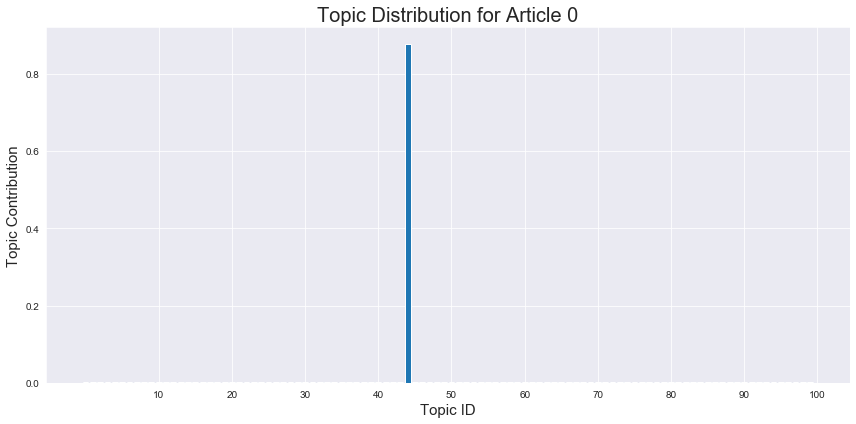

In [167]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

In [168]:
# print the top 5 contributing topics and their words
for i in doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")


44 [('network', 0.5680854), ('information', 0.14255312), ('mobile', 0.1425531), ('paper', 0.1425531), ('attack', 0.00070922077), ('iris', 0.00070922077), ('proposed', 0.00070922077), ('recognition', 0.00070922077), ('spoofing', 0.00070922077), ('architecture', 0.00070922077)] 

99 [('information', 0.1), ('mobile', 0.1), ('network', 0.1), ('paper', 0.1), ('attack', 0.1), ('iris', 0.1), ('proposed', 0.1), ('recognition', 0.1), ('spoofing', 0.1), ('architecture', 0.1)] 

36 [('information', 0.1), ('mobile', 0.1), ('network', 0.1), ('paper', 0.1), ('attack', 0.1), ('iris', 0.1), ('proposed', 0.1), ('recognition', 0.1), ('spoofing', 0.1), ('architecture', 0.1)] 

26 [('information', 0.1), ('mobile', 0.1), ('network', 0.1), ('paper', 0.1), ('attack', 0.1), ('iris', 0.1), ('proposed', 0.1), ('recognition', 0.1), ('spoofing', 0.1), ('architecture', 0.1)] 

27 [('information', 0.1), ('mobile', 0.1), ('network', 0.1), ('paper', 0.1), ('attack', 0.1), ('iris', 0.1), ('proposed', 0.1), ('recogniti

In [169]:
# select and article at random from test_df
random_article_index = np.random.randint(len(test_df))
print(random_article_index)

0


In [170]:
new_bow = dictionary.doc2bow(test_df.iloc[random_article_index,1])

In [171]:
print(test_df.iloc[random_article_index,1])

['paper', 'mobile', 'wireless', 'technology', 'paper', 'mobile', 'wireless', 'technology', 'mobile', 'wireless', 'technology', 'mobile', 'wireless', 'technology', 'technology', 'technology', 'wireless', 'wireless', 'wireless', 'paper', 'network', 'architecture', 'mobile', 'proposed', 'architecture', 'mobile', 'technology', 'network', 'architecture']


In [172]:
print(test_df.iloc[random_article_index,1])

['paper', 'mobile', 'wireless', 'technology', 'paper', 'mobile', 'wireless', 'technology', 'mobile', 'wireless', 'technology', 'mobile', 'wireless', 'technology', 'technology', 'technology', 'wireless', 'wireless', 'wireless', 'paper', 'network', 'architecture', 'mobile', 'proposed', 'architecture', 'mobile', 'technology', 'network', 'architecture']


In [173]:
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])

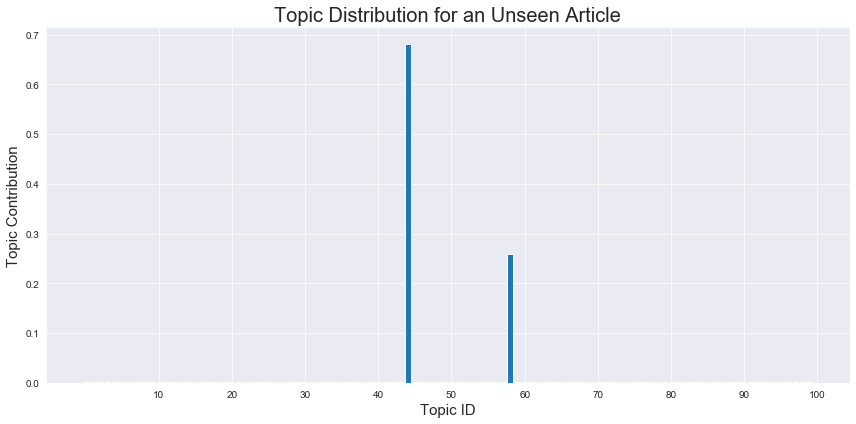

In [174]:


# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(new_doc_distribution)), new_doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for an Unseen Article", fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()



In [175]:
# print the top 8 contributing topics and their words
for i in new_doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

44 [('network', 0.5680854), ('information', 0.14255312), ('mobile', 0.1425531), ('paper', 0.1425531), ('attack', 0.00070922077), ('iris', 0.00070922077), ('proposed', 0.00070922077), ('recognition', 0.00070922077), ('spoofing', 0.00070922077), ('architecture', 0.00070922077)] 

58 [('architecture', 0.4966943), ('proposed', 0.33140495), ('network', 0.16611566), ('information', 0.0008264474), ('mobile', 0.0008264474), ('paper', 0.0008264474), ('attack', 0.0008264474), ('iris', 0.0008264474), ('recognition', 0.0008264474), ('spoofing', 0.0008264474)] 

99 [('information', 0.1), ('mobile', 0.1), ('network', 0.1), ('paper', 0.1), ('attack', 0.1), ('iris', 0.1), ('proposed', 0.1), ('recognition', 0.1), ('spoofing', 0.1), ('architecture', 0.1)] 

35 [('iris', 0.31183815), ('spoofing', 0.18722749), ('paper', 0.18722743), ('attack', 0.124922104), ('recognition', 0.12492209), ('information', 0.062616736), ('mobile', 0.00031152694), ('network', 0.00031152694), ('proposed', 0.00031152694), ('archi

In [176]:
# we need to use nested list comprehension here
# this may take 1-2 minutes...
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus]])
doc_topic_dist.shape

(4, 100)

In [178]:
def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    # lets keep with the p,q notation above
    p = query[None,:].T # take transpose
    q = matrix.T # transpose matrix
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))


In [179]:
def get_most_similar_documents(query,matrix,k=10):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

In [180]:
# this is surprisingly fast
most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist)


In [181]:
most_similar_df = train_df[train_df.index.isin(most_sim_ids)]
most_similar_df['abstract']

0    Abstract.In operations of increasingly complex...
1    Human iris is considered a reliable and accura...
2    ABSTRACT We focus on the problem of designing ...
3    Abstract—Human iris contains rich textural inf...
Name: abstract, dtype: object